In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pathology = pd.read_csv("../echo_path.csv")
facets = pd.read_csv("../echo_facets.csv")
fileA = pd.read_csv("../rerun_fileA.tsv", sep = '\t')
facetsFileA = pd.read_csv("../facets_rerun_fileA.tsv", sep = '\t')

Clean up dataframes

In [3]:
pathology['patientId'] = pathology['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
pathology['tumorSampleId'] = pathology['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
pathology['normalSampleId'] = pathology.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
pathology.drop('sample_id', axis = 1, inplace = True)
pathology = pathology[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

facets['patientId'] = facets['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
facets['tumorSampleId'] = facets['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
facets['normalSampleId'] = facets.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
facets.drop('sample_id', axis = 1, inplace = True)
facets = facets[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

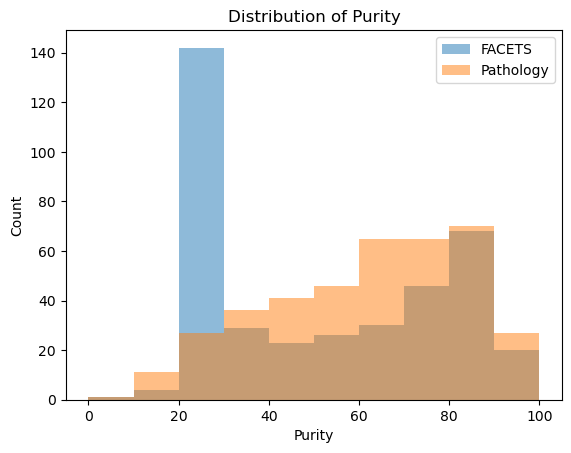

In [94]:
facetsList = facetsFileA.iloc[:, 1]
pathologyList = fileA.iloc[:, 1]
bins = [0,10,20,30,40,50,60,70,80,90,100]
plt.figure()
plt.hist(facetsList, bins = bins, alpha = 0.5, label = 'FACETS')
plt.hist(pathologyList, bins = bins, alpha = 0.5, label = 'Pathology')
plt.title("Distribution of Purity")
plt.ylabel("Count")
plt.xlabel("Purity")
plt.legend()
plt.show()

### Calls Comparison

In [ ]:
# Dictionary to track which samples/genes were called by pathology purity
pathology_score_exists = {}

for idx, row in pathology.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        string_to_hash = str(row['tumorSampleId']) + '_' + str(row['gene'])
        if string_to_hash not in pathology_score_exists :
            pathology_score_exists[string_to_hash] = idx
        

In [31]:
# Dictionary to track which samples/genes were called by facets purity
facets_score_exists = {}

# Holds the actual scores to plot
score_pathology = []
score_facets = []

# Tally up
called_only_in_facets = 0
called_only_in_pathology = 0

for idx, row in facets.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        to_check = row['tumorSampleId'] + '_' + str(row['gene'])
        if to_check not in facets_score_exists :
            facets_score_exists[to_check] = idx
            if to_check in pathology_score_exists :
                score_pathology.append(pathology.loc[pathology_score_exists[to_check], 'ecDNA_prob'])
                score_facets.append(row['ecDNA_prob'])                    
            else :
                called_only_in_facets += 1

called_only_in_pathology = len(pathology_score_exists) - len(score_pathology)

print(f"Called only in FACETS: {called_only_in_facets}")
print(f"Called only in pathology: {called_only_in_pathology}")
print(f"Called in both: {len(facets_score_exists) - called_only_in_facets}")


Called only in FACETS: 570
Called only in pathology: 378
Called in both: 160


Text(0.5, 1.0, 'ecDNA Probability for both FACETS and Pathology Called Genes')

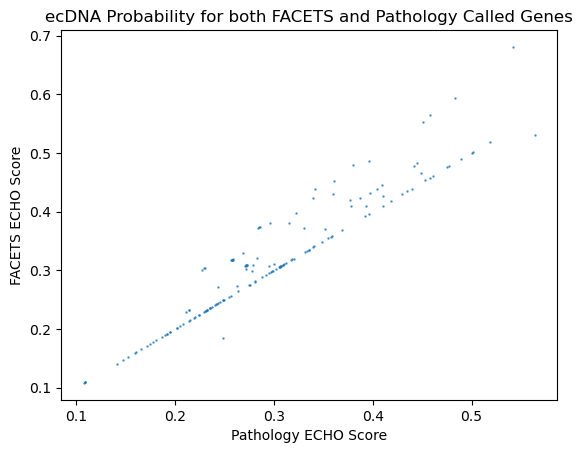

In [60]:
plt.scatter(score_pathology, score_facets, alpha = 0.7, s = 0.6)
plt.xlabel("Pathology ECHO Score")
plt.ylabel("FACETS ECHO Score")
plt.title("ecDNA Probability for both FACETS and Pathology Called Genes")

In [33]:
# Tally up
called_ecDNA_in_both = 0
called_ecDNA_in_facets = 0
called_ecDNA_in_pathology = 0

# Iterate through and count
for called in pathology_score_exists :
    if pathology.loc[pathology_score_exists[called], 'ecDNA_status'] == "ecDNA" :
        if called in facets_score_exists :
            if facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
                called_ecDNA_in_both += 1
            else :
                called_ecDNA_in_pathology += 1
        else :
            called_ecDNA_in_pathology += 1

for called in facets_score_exists :
    if facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
        if called in pathology_score_exists :
            if not facets.loc[facets_score_exists[called], 'ecDNA_status'] == "ecDNA" :
                called_ecDNA_in_facets += 1
        else :
            called_ecDNA_in_facets += 1

print(f"Both ecDNA: {called_ecDNA_in_both}")
print(f"Only ecDNA in FACETS purity: {called_ecDNA_in_facets}")
print(f"Only ecDNA in Pathology: {called_ecDNA_in_pathology}")

Both ecDNA: 5
Only ecDNA in FACETS purity: 4
Only ecDNA in Pathology: 0


### Does Purity Effect Calls?

In [34]:
# Dictionaries that connect sampleIds to the purity calls
facets_purity = {}
pathology_purity = {}

for i, row in facetsFileA.iterrows() :
    facets_purity[row['0']] = row['1']

for i, row in fileA.iterrows() :
    pathology_purity[row['sampleId']] = row['TumorPurity']

Text(0, 0.5, 'Pathology Purity')

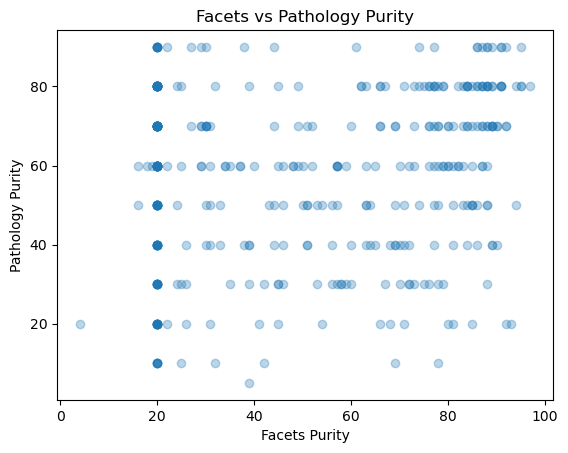

In [91]:
# Plot just the purities
plt.scatter(facetsFileA['1'], fileA['TumorPurity'], alpha = 0.3)
plt.title("Facets vs Pathology Purity")
plt.xlabel("Facets Purity")
plt.ylabel("Pathology Purity")

Getting rid of default values

In [80]:
facetsNoDefault = facetsFileA[facetsFileA['1'] != 20]
pathologyNoDefault = fileA[fileA['TumorPurity'] != 20]

Text(0, 0.5, 'Pathology Purity')

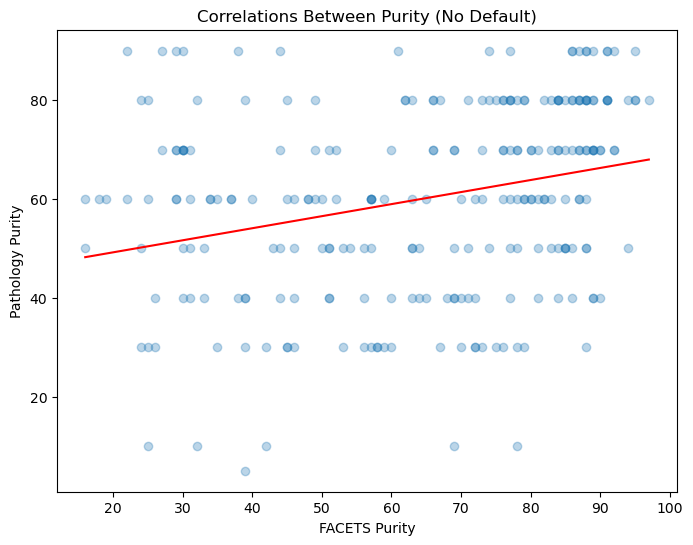

In [92]:
from scipy.stats import linregress
from scipy.optimize import curve_fit


merged = pd.merge(facetsNoDefault, pathologyNoDefault, left_on = '0', right_on = 'sampleId', how = 'inner')

plt.figure(figsize=(8, 6))
plt.scatter(merged['1'], merged['TumorPurity'], alpha = 0.3)

# Linear regression line
slope, intercept, r_value, p_value, std_err = linregress(merged['1'], merged['TumorPurity'])
x_values = np.linspace(merged['1'].min(), merged['1'].max(), 100)
y_values = intercept + slope * x_values
plt.plot(x_values, y_values, label=f'Linear Regression (R={r_value:.2f})', color='red')
plt.title("Correlations Between Purity (No Default)")
plt.xlabel("FACETS Purity")
plt.ylabel("Pathology Purity")

In [49]:
# Track the samples which have amplifiactions of some kind in pathology
has_pathology_amplifications = {}
for idx, row in pathology.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        has_pathology_amplifications[row['tumorSampleId']] = True

# Same for facets
has_facets_amplifications = {}

# These track the purities for samples only called amplified in facets
facets_only_facets = []
facets_only_pathology = []

# Iterate and fill
for idx, row in facets.iterrows() :
    if not pd.isna(row['ecDNA_prob']) :
        has_facets_amplifications[row['tumorSampleId']] = True
        if not row['tumorSampleId'] in has_pathology_amplifications :

            facets_only_facets.append(int(facets_purity[row['tumorSampleId']]))
            facets_only_pathology.append(int(pathology_purity[row['tumorSampleId']]))

In [55]:
# Track purities for samples only called amplified in pathology
pathology_only_facets = []
pathology_only_pathology = []

for i in has_pathology_amplifications :
    if not i in has_facets_amplifications :
        pathology_only_facets.append(int(facets_purity[i]))
        pathology_only_pathology.append(int(pathology_purity[i]))

Text(0.5, 1.0, 'Facets vs Pathology Purity on Only FACETS Called Amplifications')

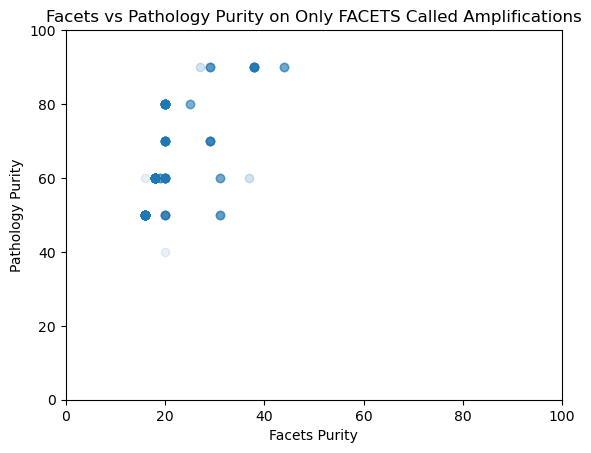

In [56]:
plt.scatter(facets_only_facets, facets_only_pathology, alpha = 0.1)
plt.xlim((0,100))
plt.ylim((0,100))
plt.xlabel("Facets Purity")
plt.ylabel("Pathology Purity")
plt.title("Facets vs Pathology Purity on Only FACETS Called Amplifications")

Text(0.5, 1.0, 'Facets vs Pathology Purity on Only Pathology Called Amplifications')

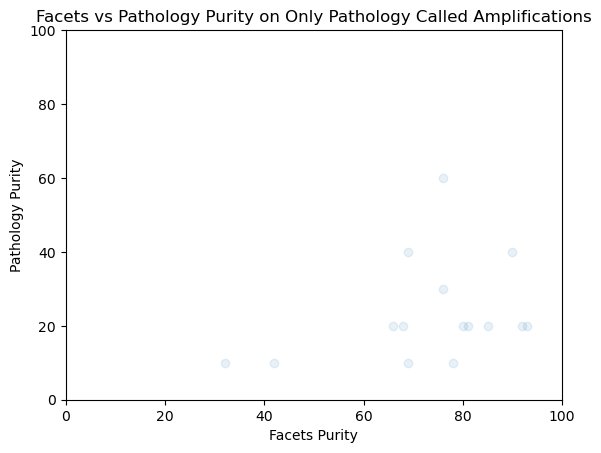

In [57]:
plt.scatter(pathology_only_facets, pathology_only_pathology, alpha = 0.1)
plt.xlim((0,100))
plt.ylim((0,100))
plt.xlabel("Facets Purity")
plt.ylabel("Pathology Purity")
plt.title("Facets vs Pathology Purity on Only Pathology Called Amplifications")